## **Izdiharti Noni Pertiwi**
dataset rockpaperscissors

In [1]:
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /tmp/rockpaperscissors.zip

--2021-07-16 13:59:33--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  3.02MB/s    in 45s     

2021-07-16 14:00:19 (6.81 MB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]



In [2]:
# melakukan ekstraksi pada file zip
import zipfile,os,shutil
local_zip = '/tmp/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [3]:
base_dir = '/tmp/rockpaperscissors/rps-cv-images'
roc_dir = os.path.join(base_dir,'rock')
pap_dir = os.path.join(base_dir, 'paper')
sci_dir = os.path.join(base_dir, 'scissors')

In [4]:
total_rock = len(os.listdir(roc_dir))
total_paper = len(os.listdir(pap_dir))
total_scissors = len(os.listdir(sci_dir))

# Mencetak jumlah data rock paper scissor
print("Total Data Paper Image      : ",total_paper)
print("Total Data Rock Image       : ",total_rock)
print("Total Data Scissors Image  : ",total_scissors)

Total Data Paper Image      :  712
Total Data Rock Image       :  726
Total Data Scissors Image  :  750


In [5]:
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [6]:
# Pembuatan Train dan Validation  data generator 
# Untuk augmentasi gambar
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#Ukuran validation 20% dari dataset
val_size = 0.2

Train_datagen = ImageDataGenerator(
    rotation_range = 30,
    brightness_range = [0.2,1.0],
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = "nearest",
    rescale = 1./255,
    validation_split = val_size
)

Validation_datagen = ImageDataGenerator(
    rotation_range = 30,
    brightness_range = [0.2,1.0],
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = "nearest",
    rescale = 1./255,
    validation_split = val_size
)

In [7]:
# Train dan Validation generator  dengan mode categorical
Train_generator = Train_datagen.flow_from_directory(
    base_dir,
    target_size = (150,150),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 16,
    shuffle = True,
    subset = "training"
)

Validation_generator = Validation_datagen.flow_from_directory(
    base_dir,
    target_size = (150,150),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 16,
    shuffle = False,
    subset = "validation"
)

Found 1751 images belonging to 3 classes.
Found 437 images belonging to 3 classes.


In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

In [9]:
# Pembuatan Model dengan tipe Sequential
Model = Sequential(
    [
     # Activation menggunakan relu + softmax
     Conv2D(32, (3,3), strides = (1,1), activation = 'relu' , input_shape = (150,150,3)),
     MaxPooling2D(pool_size = (2,2), padding = 'valid'),
     Conv2D(64, (3,3), strides = (1,1), activation = 'relu' ),
     MaxPooling2D(pool_size = (2,2), padding = 'valid'),
     Conv2D(128, (3,3), strides = (1,1), activation = 'relu' ),
     MaxPooling2D(pool_size = (2,2), padding = 'valid'),
     Flatten(),
     # Droupout
     Dropout(0.2),
     Dense(128, activation = 'relu'),
     Dense(3, activation='softmax')
    ]
)

In [10]:
# Penggunaan Optimizer 'Adam' dengan learning rate 0.00146
Adam(learning_rate=0.00146, name='Adam')
Model.compile(optimizer = 'Adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [16]:
ACCURACY_THRESHOLD = 0.92

# Implement callback function to stop training
# when accuracy reaches e.g. ACCURACY_THRESHOLD = 0.92
class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if(logs.get('accuracy') > ACCURACY_THRESHOLD):
			print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))
			self.model.stop_training = True

# Instantiate a callback object     
callbacks = myCallback()

In [17]:
def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

Model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 36992)             0

In [18]:
# Proses Training 
batch_size = 16
with tf.device("/device:GPU:0"):
  history = Model.fit(Train_generator, 
                    epochs =  40, 
                    steps_per_epoch = 1751//batch_size, 
                    validation_data = Validation_generator, 
                    verbose = 1, 
                    validation_steps = 437//batch_size,
                    callbacks =[lr_schedule, callbacks])

Epoch 1/40

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
109/109 [==============================] - 82s 756ms/step - loss: 0.5476 - accuracy: 0.8012 - val_loss: 0.3862 - val_accuracy: 0.8542
Epoch 2/40

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
109/109 [==============================] - 82s 754ms/step - loss: 0.2993 - accuracy: 0.8882 - val_loss: 0.3677 - val_accuracy: 0.8449
Epoch 3/40

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
109/109 [==============================] - 82s 753ms/step - loss: 0.2238 - accuracy: 0.9233 - val_loss: 0.2087 - val_accuracy: 0.9282

Reached 92.00% accuracy, so stopping training!!


Saving WhatsApp Image 2021-07-01 at 20.32.11.jpeg to WhatsApp Image 2021-07-01 at 20.32.11 (1).jpeg


Hasil Prediksi :  [0. 1. 0.] 

Kategori Gambar : Rock


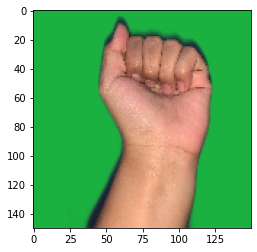

In [20]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Upload File ke google colabs
uploaded = files.upload()

# pengkondisian
for file_upload in uploaded.keys():

  path = file_upload
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  # Membuat numpy vstack array untuk hasil prediksi 
  images = np.vstack([x])
  classes = Model.predict(images, batch_size=16)
  
  print("\n")
  print('Hasil Prediksi : ',classes[0],'\n')

  if classes[0][0] == 1:
    print('Kategori Gambar : Paper')
  elif classes[0][1] == 1:
    print('Kategori Gambar : Rock')
  else:
    print('Kategori Gambar : Scissor')

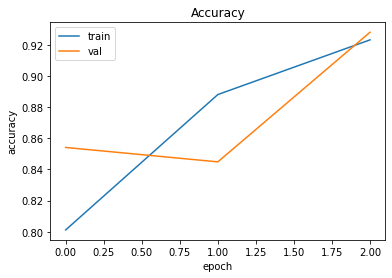

In [25]:
# Mengambil Nilai Accuracy 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

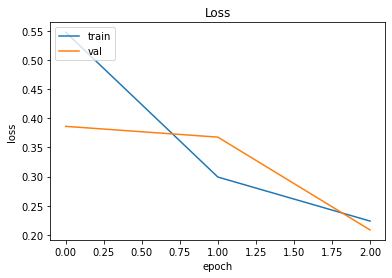

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [29]:
import warnings
# Menghilangkan Warning
warnings.filterwarnings('ignore')
# Convert Model.
converter = tf.lite.TFLiteConverter.from_keras_model(Model)
tflite_model = converter.convert()
# Save the model.
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpf8b6w6ss/assets


INFO:tensorflow:Assets written to: /tmp/tmpf8b6w6ss/assets
